In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X_with_callback.npy')
y=np.load('data_y_with_callback.npy')

In [3]:
len(X)

2145

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 401412    
Total params: 23,989,124
Trainable params: 23,936,004
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='ResNet_1.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [11]:
class_weight = {0: 0.8,
                1: 1,
                2: 1,
                3: 1}

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=60, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/60
54/53 [==============================] - 36s 662ms/step - loss: 1.9127 - acc: 0.2925 - auc: 0.5467 - precision: 0.2876 - recall: 0.2074 - f1score: 0.0947 - val_loss: 3.8268 - val_acc: 0.2564 - val_auc: 0.5383 - val_precision: 0.2888 - val_recall: 0.2014 - val_f1score: 0.0784
Epoch 2/60
54/53 [==============================] - 18s 334ms/step - loss: 1.7860 - acc: 0.3217 - auc: 0.5451 - precision: 0.3023 - recall: 0.2140 - f1score: 0.1001 - val_loss: 1.6495 - val_acc: 0.2424 - val_auc: 0.5492 - val_precision: 0.3078 - val_recall: 0.2110 - val_f1score: 0.0927
Epoch 3/60
54/53 [==============================] - 18s 333ms/step - loss: 1.6677 - acc: 0.3392 - auc: 0.5560 - precision: 0.3153 - recall: 0.2128 - f1score: 0.1054 - val_loss: 1.6096 - val_acc: 0.2751 - val_auc: 0.5616 - val_precision: 0.3239 - val_recall: 0.2161 - val_f1score: 0.0964
Epoch 4/60
54/53 [==============================] - 18s 334ms/step - loss: 1.6397 - acc: 0.3537 - auc: 0.5665 - precision: 0.3286 - recall:

54/53 [==============================] - 18s 332ms/step - loss: 1.2702 - acc: 0.4627 - auc: 0.6643 - precision: 0.4369 - recall: 0.3068 - f1score: 0.1300 - val_loss: 1.6931 - val_acc: 0.4056 - val_auc: 0.6652 - val_precision: 0.4378 - val_recall: 0.3079 - val_f1score: 0.1203
Epoch 30/60
54/53 [==============================] - 18s 332ms/step - loss: 1.3166 - acc: 0.4656 - auc: 0.6663 - precision: 0.4388 - recall: 0.3088 - f1score: 0.1314 - val_loss: 1.6248 - val_acc: 0.4196 - val_auc: 0.6673 - val_precision: 0.4398 - val_recall: 0.3097 - val_f1score: 0.1212
Epoch 31/60
54/53 [==============================] - 18s 332ms/step - loss: 1.3023 - acc: 0.4586 - auc: 0.6683 - precision: 0.4408 - recall: 0.3106 - f1score: 0.1306 - val_loss: 1.7215 - val_acc: 0.4033 - val_auc: 0.6691 - val_precision: 0.4418 - val_recall: 0.3116 - val_f1score: 0.1162
Epoch 32/60
54/53 [==============================] - 18s 332ms/step - loss: 1.2864 - acc: 0.4685 - auc: 0.6699 - precision: 0.4426 - recall: 0.3123 

54/53 [==============================] - 18s 332ms/step - loss: 1.1802 - acc: 0.4866 - auc: 0.7047 - precision: 0.4783 - recall: 0.3449 - f1score: 0.1376 - val_loss: 1.5641 - val_acc: 0.4755 - val_auc: 0.7053 - val_precision: 0.4789 - val_recall: 0.3455 - val_f1score: 0.1326
Epoch 58/60
54/53 [==============================] - 18s 332ms/step - loss: 1.1787 - acc: 0.5076 - auc: 0.7059 - precision: 0.4795 - recall: 0.3460 - f1score: 0.1401 - val_loss: 1.7585 - val_acc: 0.4545 - val_auc: 0.7064 - val_precision: 0.4802 - val_recall: 0.3466 - val_f1score: 0.1292
Epoch 59/60
54/53 [==============================] - 18s 332ms/step - loss: 1.1741 - acc: 0.5047 - auc: 0.7069 - precision: 0.4807 - recall: 0.3471 - f1score: 0.1391 - val_loss: 1.7014 - val_acc: 0.4242 - val_auc: 0.7074 - val_precision: 0.4812 - val_recall: 0.3475 - val_f1score: 0.1257
Epoch 60/60
54/53 [==============================] - 18s 331ms/step - loss: 1.1994 - acc: 0.4918 - auc: 0.7077 - precision: 0.4815 - recall: 0.3479 

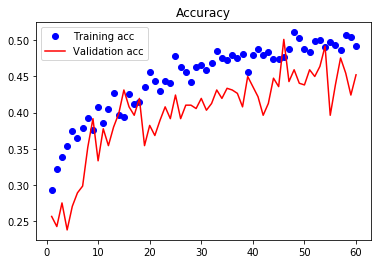

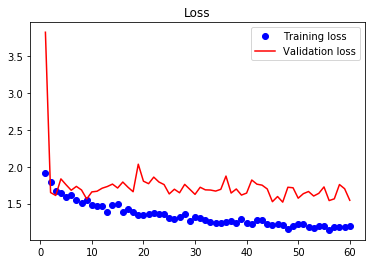

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [14]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 1s 3ms/step
loss: 1.544, accuracy: 0.452, auc: 0.708, precision: 0.482, recall: 0.348, f1score: 0.129


In [17]:
from keras.models import Model, load_model

new_model = models.load_model('ResNet_1.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [18]:
_loss, _acc, _auc, _precision, _recall, _f1score = new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 3s 7ms/step
loss: 1.519, accuracy: 0.443, auc: 0.729, precision: 0.509, recall: 0.375, f1score: 0.128
